## Imports

In [12]:
import pandas as pd
import numpy as np
from psaw import PushshiftAPI
import datetime 
from bs4 import BeautifulSoup 
import requests
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Enter City (Emphasis on city) where natural disaster occured

In [13]:
searchcity = 'trinity'

## Creates a list of URLS to search through

In [14]:
url_list=[]
for page in range(1,6000):
    url_list.append("https://api.adzuna.com:443/v1/api/jobs/us/search/"+ str(page) +"?app_id=d3330ea8&app_key=cbcbe79274381fae5af07fb6828067ce&results_per_page=100&where="+str(searchcity)+"&sort_direction=up&sort_by=date&max_days_old=365")

## Starts pulling data from Adunza API for jobs

In [15]:
spot = 1
pulleddata = []
for url in url_list:
    try: 
        requests.get(url).json()['results'][0]
        pulleddata.append(requests.get(url).json())
        print(str(spot) + '0 job ads pulled')
        spot += 1
        time.sleep(1)
    except: 
        print('This is the end of data')
        break

10 job ads pulled
This is the end of data


## Structures data 

In [16]:
structureddata = []
for x in range(0, len(pulleddata)):
    for y in pulleddata[x]['results']:
        structureddata.append(y)

## Creates Dataframe and creates a saved file (in case of "oopsies")

In [17]:
df = pd.DataFrame()

for x in range(0, len(structureddata)):
    try:
        df['company'] = [structureddata[x]['company']['display_name'] for x in range(0, len(structureddata))]
        df['date'] = [structureddata[x]['created'][:7] for x in range(0, len(structureddata))]
        df['title']= [structureddata[x]['title']for x in range(0, len(structureddata))]
        df['All_Sectors']= [structureddata[x]['category']['label']for x in range(0, len(structureddata))]

    except:
        print('error')
        pass

try: 
    df.drop_duplicates(inplace=True)
except:
    pass

In [18]:
df

,company,date,title,All_Sectors
0,J.S. Helwig and Sons LLC,2018-05,Company Truck Driver (CDL-A),Unknown
1,C.R. England,2018-06,"CDL Training School We Train, We Hire - Guaran...",Logistics & Warehouse Jobs
2,C.R. England,2018-09,"Become a Truck Driver We Train, We Hire - Guar...",Logistics & Warehouse Jobs
3,C.R. England,2018-09,"Entry Level CDL Truck Driver We Train, We Hire...",Unknown
4,C.R. England,2018-10,Entry-Level CDL-A Truck Drivers - Paid Trainin...,Unknown
5,C.R. England,2018-10,Recent Grad CDL-A Truck Driver - Paid Training,Unknown
6,C.R. England,2018-10,Truck Driver Class A CDL Recent Grads - Paid T...,Unknown
7,C.R. England,2018-11,No Experience - We Train New Truck Drivers,Unknown
8,Care.com,2018-11,Nanny Needed For 1 Child In Trinity.,Social work Jobs
9,Dollar General,2018-12,"LEAD SALES ASSOCIATE-PT in TRINITY, TX",Unknown


## Changing date to datetime data type

In [19]:
try:
    df['date'] = pd.to_datetime(df['date'])
except:
    pass

## Null (all should be 0)

In [20]:
df.isnull().sum()

company        0
date           0
title          0
All_Sectors    0
dtype: int64

## Number of Data Points

In [21]:
len(df)

19

## Frequency of posting by dates

In [22]:
df['date'].value_counts().sort_index()

2018-05-01    1
2018-06-01    1
2018-09-01    2
2018-10-01    3
2018-11-01    2
2018-12-01    5
2019-01-01    5
Name: date, dtype: int64

## Most common Sectors posted

In [23]:
df['All_Sectors'].value_counts()

Unknown                       11
Logistics & Warehouse Jobs     3
Engineering Jobs               1
Travel Jobs                    1
Social work Jobs               1
Healthcare & Nursing Jobs      1
Admin Jobs                     1
Name: All_Sectors, dtype: int64

## Industry Dummyvariable DataFrame

In [24]:
industrygraphs = pd.get_dummies(df['All_Sectors'])
industry = pd.concat([df, industrygraphs], axis=1)
for x in industry.columns[6:]:
    print(x)

Healthcare & Nursing Jobs
Logistics & Warehouse Jobs
Social work Jobs
Travel Jobs
Unknown


## Saves Dataframe (with dummies, to cityname.csv)

In [25]:
industry.to_csv(str(searchcity)+'data.csv')

## Creating of graphing data

In [26]:
daterange = pd.date_range(start="2018-01", end='2019-01', freq='M')
graphme = pd.DataFrame(columns=[x for x in industry.columns[6:]], index= daterange)
graphme

,Healthcare & Nursing Jobs,Logistics & Warehouse Jobs,Social work Jobs,Travel Jobs,Unknown
2018-01-31,NaN,NaN,NaN,NaN,NaN
2018-02-28,NaN,NaN,NaN,NaN,NaN
2018-03-31,NaN,NaN,NaN,NaN,NaN
2018-04-30,NaN,NaN,NaN,NaN,NaN
2018-05-31,NaN,NaN,NaN,NaN,NaN
2018-06-30,NaN,NaN,NaN,NaN,NaN
2018-07-31,NaN,NaN,NaN,NaN,NaN
2018-08-31,NaN,NaN,NaN,NaN,NaN
2018-09-30,NaN,NaN,NaN,NaN,NaN
2018-10-31,NaN,NaN,NaN,NaN,NaN


In [27]:
graphme['2018-02']

,Healthcare & Nursing Jobs,Logistics & Warehouse Jobs,Social work Jobs,Travel Jobs,Unknown
2018-02-28,NaN,NaN,NaN,NaN,NaN


In [28]:
graphme.fillna(0, inplace=True)

In [29]:
for x in range(6, (len(industry.columns))):
    for date in industry[industry[str(industry.columns[x])] == 1]['date']:
        for inde in graphme.index:
            if str(date)[0:7] == str(inde)[:7]:
                graphme[str(inde)[0:7]][str(industry.columns[x])]+=1
graphme.to_csv(str(searchcity)+"graphdata.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [30]:
graphme

,Healthcare & Nursing Jobs,Logistics & Warehouse Jobs,Social work Jobs,Travel Jobs,Unknown
2018-01-31,0,0,0,0,0
2018-02-28,0,0,0,0,0
2018-03-31,0,0,0,0,0
2018-04-30,0,0,0,0,0
2018-05-31,0,0,0,0,1
2018-06-30,0,1,0,0,0
2018-07-31,0,0,0,0,0
2018-08-31,0,0,0,0,0
2018-09-30,0,1,0,0,1
2018-10-31,0,0,0,0,3


## Plotly graph

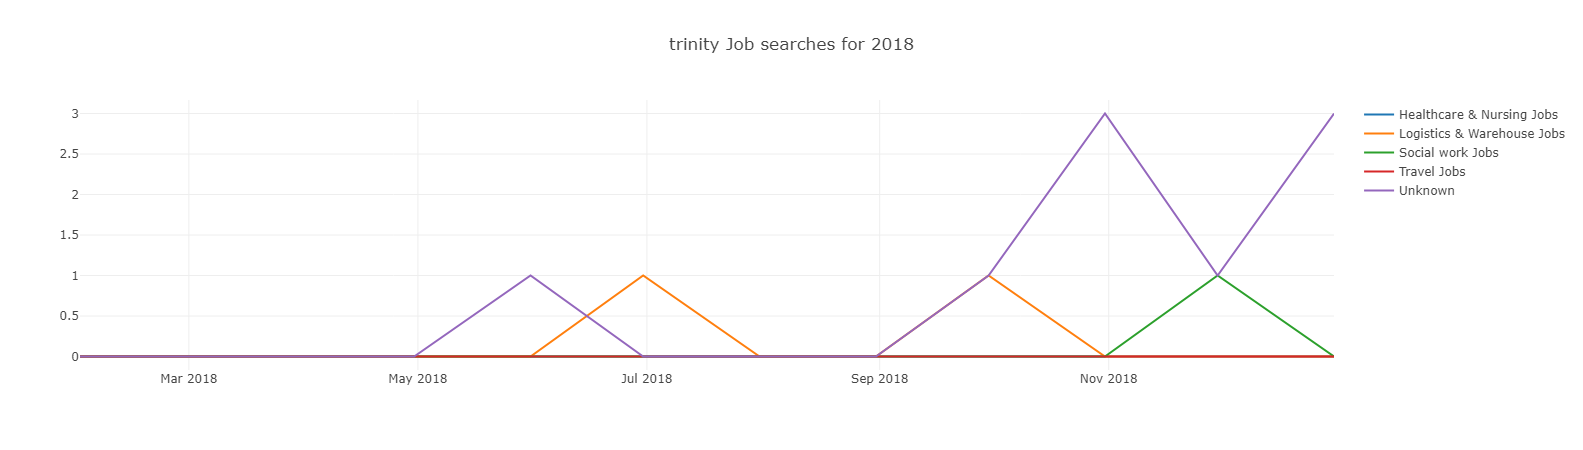

In [31]:
traces = {}
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

for num in range(0, (len(graphme))):
    try:
        traces['trace'+str(num)] = dict(
                    x= graphme.index,
                    y= graphme[graphme.columns[num]],
                    mode='lines',
                    name= graphme.columns[num])
        print(name)
    except:
        pass

data = [traces['trace'+str(x)] for x in range(0, (len(traces)))]

plot({'data':data,
       'layout' : {'title': str(searchcity) +" Job searches for 2018"},
     }, filename=str(searchcity)+"PLOTLY.html")


iplot({'data':data,
       'layout' : {'title': str(searchcity) +" Job searches for 2018"}})

## Matplotlib

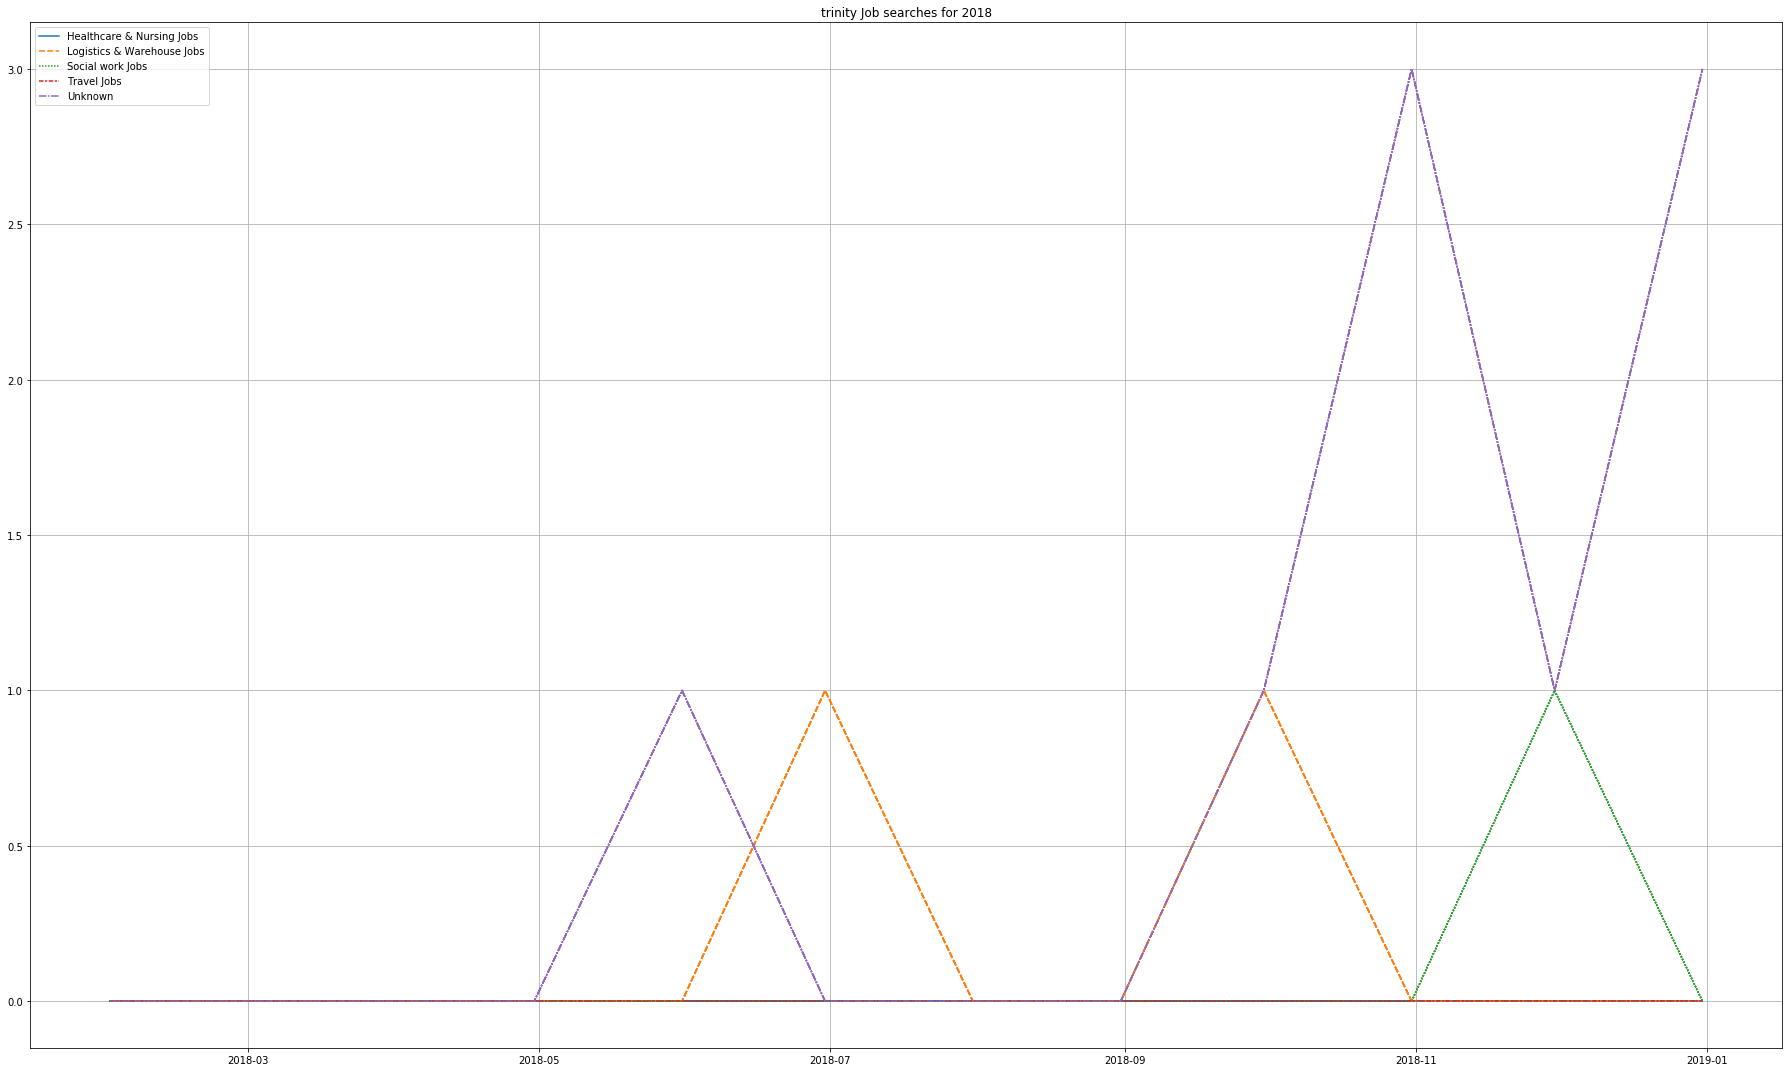

In [32]:
plt.figure(figsize=(25,15))
for num in range(6, len(industry.columns)):
    sns.lineplot(data = graphme)
plt.legend(labels=graphme.columns)
plt.title(str(searchcity) + " Job searches for 2018")
plt.grid()
plt.tight_layout()
plt.savefig(str(searchcity)+"Matplotlib.jpg")